In [28]:
import numpy as np
from astropy.io import fits
from DS_healpix_fragmentation import one_pixel_fragmentation, draw_x_h, matr2dict, radec2pix
from DS_Planck_Unet import draw_pic, check_gen, unet_planck, gen_data
import healpy as hp
from matplotlib import pyplot as plt
from DS_detector import scan_none
import pandas as pd
from skimage.draw import circle

In [ ]:
nilc = None
with fits.open('/home/rt2122/Data/Planck/y/nilc_ymaps.fits') as hdul:
    data = hdul[1].data
    print(repr(hdul[1].header))
    nilc = np.array(data['FULL'])

In [ ]:
nilc.shape, hp.nside2npix(2048) 

In [ ]:
np.save('/home/rt2122/Data/Planck/normalized/y/nilc', nilc)

In [ ]:
def draw_pic_new(matr, dirname='/home/rt2122/Data/Planck/normalized/', y=False):
    import os
    import numpy as np
   
    if y:
        dirname = os.path.join(dirname, 'y')
        
    files = sorted(next(os.walk(dirname))[-1])
    pic = np.zeros(list(matr.shape) + [len(files)])
    
    for i_f, file in enumerate(files):
        i_s = np.load(os.path.join(dirname, file))
        
        for x in range(pic.shape[0]):
            pic[x, :, i_f] = i_s[matr[x]]
    return pic


In [ ]:
matr = one_pixel_fragmentation(2, 6, 10)

In [ ]:
ypic = draw_pic_new(matr, y=True)

In [ ]:
nilc = nilc.astype(np.float64)

In [ ]:
plt.imshow(ypic[:64,:64,0])

In [ ]:
model = unet_planck(
    weights='/home/rt2122/Models/planck_z/b40.ep0011-vl0.121560-l0.125252.h5')

In [ ]:
test_gen = gen_data('/home/rt2122/Data/clusters/planck_z.csv', [6], 1, 
                    min_rad=0.08, retmatr=True) 

In [ ]:
check_gen_new(test_gen, model, y=True)

In [ ]:
def check_gen_new(gen, model=None, thr=0.8, y=False):
    from matplotlib import pyplot as plt
    import numpy as np
    pic, mask, matr = None, None, None
    if y:
        pic, mask, matr = next(gen)
    else:
        pic, mask = next(gen)
    print(pic.shape, mask.shape)
    pic = pic[0]
    mask = mask[0]
    fig, ax = plt.subplots(3, 3, figsize=(12, 12))
    for i in range(3):
        for j in range(2):
            ax[i][j].imshow(pic[:,:,i+3*j])
    ax[0][2].imshow(mask[:,:,0])
    if not (model is None):
        ans = model.predict(np.array([pic]))
        ax[1][2].imshow(ans[0,:,:,0])
        if y:
            cpic = draw_pic(matr[0], y=True)
            ax[2][2].imshow(cpic[:,:,0])
        else:
            ax[2][2].imshow((ans[0,:,:,0] >= thr).astype(np.float32))

In [2]:
def select_small_square(x, y, pic):
    pic = np.copy(pic)
    pic[x*64:(x+1)*64, y*64:(y+1)*64,:]+=0.5
    return pic

In [3]:
def clusters_of_test_pix(x, y, model, pic, ypic, cl_pics, big_matr):
    import numpy as np
    from matplotlib import pyplot as plt
    
    
    grids = np.zeros(list(big_matr.shape)+[1])
    for i in range(0, grids.shape[0], 64):
        grids[i,:,0] = 1
        grids[i+1,:,0] = 1
        grids[:,i,0] = 1
        grids[:,i+1,0] = 1 
        
    ans = model.predict(np.array([pic[x*64:(x+1)*64,y*64:(y+1)*64]]))
    for i in range(len(cl_pics)):
        if cl_pics[i] is None:
            cl_pics[i] = np.zeros(list(big_matr.shape)+[1])
    found_cl_pic, all_cl_pic, fp_pic = cl_pics
    
    fig, ax = plt.subplots(1, 3, figsize=(16, 8))
    ax[0].imshow(select_small_square(x, y, np.dstack([found_cl_pic + grids, 
                                    all_cl_pic-found_cl_pic + grids, fp_pic])))
    ax[1].imshow(ans[0,:,:,0])
    ax[2].imshow(ypic[x*64:(x+1)*64,y*64:(y+1)*64,0])

In [4]:
model = unet_planck(
    weights='/home/rt2122/Models/planck_z/b40.ep0195-vl0.074489-l0.018017.h5')

In [5]:
matr = one_pixel_fragmentation(2, 6, 10)

In [6]:
pic = draw_pic(matr)

In [7]:
ypic = draw_pic(matr, y=True)

In [ ]:
coords = scan_none(6, model, ret_coords=True, cl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


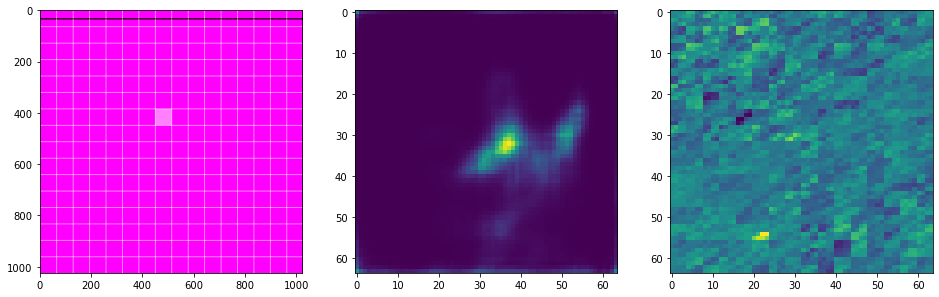

In [14]:
clusters_of_test_pix(6, 7, model, pic, ypic, [all_clusters] * 3, matr)

In [8]:
df = pd.read_csv('/home/rt2122/Data/clusters/planck_z.csv')

In [12]:
mdict = matr2dict(matr)

In [129]:
all_clusters = draw_x_h_n(df['RA'], df['DEC'], np.ones(len(df)), 
                          2048, mdict, 
                        list(matr.shape), coef=0.02)

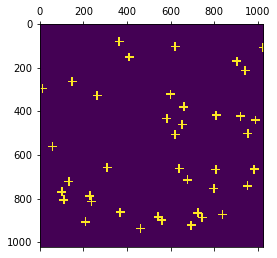

In [130]:
plt.matshow(all_clusters[:,:])

In [128]:
def make_x_n(x, y, size, shape, th=3):
    import numpy as np
    size = int(size)
    coords = []
    coords.extend([(xx, yy) 
                   for xx in range(max(x-th,0), min(x+th+1,shape[0]-1)) 
                   for yy in range(max(y-size,0), min(y+size+1,shape[1]-1))])
    coords.extend([(xx, yy) 
                   for xx in range(max(x-size,0), min(x+size+1,shape[0]-1)) 
                   for yy in range(max(y-th,0), min(y+th+1,shape[1]-1))])
    coords = np.array(coords)
    if len(shape) > 2:
        return coords[:,0], coords[:,1], np.zeros(len(coords))
    return coords[:,0], coords[:,1]

def draw_x_h_n(ra, dec, data, nside, mdict, shape, coef=0.02):
    import numpy as np
    from skimage.draw import circle

    coef = shape[0] * coef / max(data)
    pic = np.zeros(shape, dtype=np.uint8)
    pix = radec2pix(ra, dec, nside)
    for i in range(len(pix)):
        if pix[i] in mdict:
            x, y = mdict[pix[i]]
            x_pic = make_x_n(x, y, data[i] * coef, shape=shape)
            pic[x_pic] = 1
    
    return pic


In [29]:
c = circle(5, 6, 10, shape=(20, 20, 1))

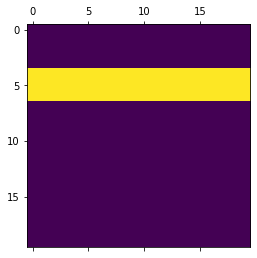

In [65]:
a = np.zeros((20,20))
a[make_x_n(5, 5, 1, (10, 10))]=1
plt.matshow(a)

In [67]:
make_x_n(5, 5, 1, (10, 10))

array([[5, 5, 5, 4, 5, 6],
       [4, 5, 6, 5, 5, 5]])

In [68]:
circle(5, 5, 2, shape=(10,10))

(array([4, 4, 4, 5, 5, 5, 6, 6, 6]), array([4, 5, 6, 4, 5, 6, 4, 5, 6]))

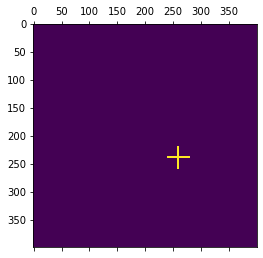

In [123]:
a = np.zeros((400, 400))
a[make_x_n(939-700, 459-200, 20, (1001, 1000))]=1
plt.matshow(a)

In [120]:
make_x_n(939, 459, 1, (1001, 1000))

(array([938, 938, 938, 939, 939, 939, 940, 940, 940, 938, 938, 938, 939,
        939, 939, 940, 940, 940]),
 array([458, 459, 460, 458, 459, 460, 458, 459, 460, 458, 459, 460, 458,
        459, 460, 458, 459, 460]))